<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/3.%20Frameworks%20Software/Practica3.3.%20Keras%3A%20un%20primer%20ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3.4. Primer ejemplo con Keras

A continuación tendremos nuestro primer [Jupyter Notebook](http://jupyter.org) completo de Deep Learning con [Keras](https://keras.io) (y Python usando de fondo TensorFlow). Podemos obeservar en la figura las capas en las que consiste Keras, desde el hardware soportado (abajo) hasta modelos completos (arriba). Tensorflow es el motor principal de Keras, aunque también hay cierto soporte con CNTK y Theano (lamentablemente, ya sin soporte). Desde Tensorflow 2, Keras forma parte de la API como medio de dar un nivel mayor de abstracción.

<!--<img src="./imgs/env.png" width=500px/>
![](https://github.com/miguelamda/DL/raw/master/3.%20Frameworks%20Software/imgs/Env.png)-->

Construiremos un ejemplo de red neuronal muy simple, con apenas un par de capas, para abordar el famoso problema [MNIST](https://en.wikipedia.org/wiki/MNIST_database). Nuestro objetivo es ver el flujo de trabajo habitual para describir un modelo en Keras, pero sin profundizar en los detalles, que veremos en temas posteriores.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="300px" />

<!--Además, también usaremos este notebook para familiarizarnos con el uso de Jupyter como entorno de desarrollo y experimentación. Para ejecutar los diversos chunks (así se llaman las únidades de código que conforman un notebook) de este notebook puedes pulsar en el botón *Run* (que hay a la izquierda de cada uno de ellos), o bien situando el cursor dentro del chunk y presionando la combinación de teclas *Shift+Enter*. También tienes la opción de usar las opciones de ejecución en el menú *Run* de la barra del navegador Jupyter. Ten en cuenta que algunas opciones pueden cambiar dependiendo del entorno en el que estés trabajando con este notebook (Jupyter Notebook, Jupyter Lab, o Collab de Google.. cualquiera de los tres funcionan de forma similar, pero con ligeras diferencias). -->

El primer paso es cargar la librería keras que permitirá interactuar a Python con la librería de Deep Learning que usemos (en nuestro caso, [Tensorflow](https://www.tensorflow.org)). 

En la celda también mostramos la versión de keras que estamos usando e información de los dispositivos que usará Tensorflow para los cálculos siguientes.

In [1]:
from tensorflow import keras
print(keras.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 180145687865138690
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17277203658686687905
physical_device_desc: "device: XLA_CPU device"
]


## 1. Preparación de los datos

El primer paso de todo modelado es la preparación y carga de los datos. En nuestro caso, del problema [MNIST](http://yann.lecun.com/exdb/mnist/), que consta de una gran base de datos de dígitos escritos a mano y que es tan habitual que se ha convertido en un ejemplo paradigmático dentro de Machine Learning.

El trabajo de preprocesamiento necesario para poder aplicar un modelo a este problema puede ser considerable pero, afortunadamente, Keras proporciona una instrucción directa para descargar las imágenes que representan los miles de dígitos escritos a mano (ya con formato unificado de 28x28 pixels en escala de grises, es decir, un solo canal de color).

Para poder cargar los datos que trae de ejemplo Keras hay que seguir dos pasos:
 * primero, cargar la librería de Keras que porporciona las herramientas para trabajar con el dataset concreto (que suelen estar en el paquete `keras.datasets`, en este caso llamado `mnist`); y,
 * segundo, ejecutar el proceso de carga de los datos (la librería proporciona la función `load_data()`). Ha de tenerse en cuenta que la primera vez que se realiza este proceso los datos se descargan desde un repositorio que viene por defecto predefinido en ese paquete, ya que, debido a su tamaño, no se instalan junto con la librería, sino únicamente cuando el usuario los necesita:

In [2]:
from keras.datasets import mnist

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Observa que el proceso de carga de datos separa adecuadamente las diversas partes de que consta este dataset:  (_conjunto de entrenamiento_, _conjunto de test_), y cada uno de estos conjuntos está formado por un conjunto de datos (imágenes, en este caso concreto), con sus respectivas etiquetas de clasificación (_labels_). Además, aprovechamos la capacidad sintáctica de Python para realizar la carga de todos estos conjuntos en un solo paso (haciendo una 
asignación múltiple).

Podemos explorar un poco cómo son cada una de estas variables haciendo uso de instrucciones específicas de Python que nos dan información acerca de su estructura y muestra los primeros valores:

In [3]:
train_data.shape

(60000, 28, 28)

In [4]:
len(train_labels)

60000

In [5]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [6]:
test_data.shape

(10000, 28, 28)

In [7]:
len(test_labels)

10000

In [8]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Para visualizar alguna de las imágenes que hay en el dataset, podemos definirnos una función que haga uso de la instrucción adecuada de, por ejemplo, la librería `matplotlib`:

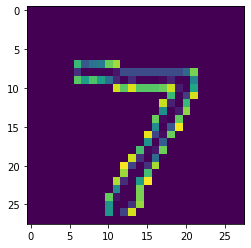

In [9]:
from matplotlib import pyplot as plt
import numpy as np

def gen_image(arr):
    conv = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(conv, interpolation='nearest')
    return plt

gen_image(test_data[0]).show()

El flujo de trabajo es similar al que se sigue siempre en los procesos de ML Supervisado, y que hemos analizado en el tema anterior: 
  1. Mostramos al modelo (una red neuronal, en nuestro caso) los datos de *entrenamiento*, `train_data` y `train_labels`.
  2. El modelo debe *aprender* a asociar las imágenes con las etiquetas asociadas.
  3. Por último, verificamos el aprendizaje realizado comprobando sobre `test_data` que las respuestas dadas por el modelo (*predicciones*) coinciden con las almacenadas en `test_labels`.

<img src="https://thumbs.gfycat.com/FickleHorribleBlackfootedferret-small.gif" />

## 2. Definición del modelo

Ya estamos en condiciones de definir una red neuronal que consumirá los datos anteriores para ver si somos capaces de dar una primera solución al problema del reconocimiento de dígitos manuscritos. Como solo estamos haciendo una primera aproximación a Keras, la red definida será muy básica, con solo una capa de entrada y una de salida:

  1. Vamos a situar una capa de entrada con 784 (= 28 * 28) neuronas (que recibirán cada uno de los 784 pixels de cada imagen), con función de activación ReLU, y 
  2. una capa de salida con 10 neuronas (una neurona para cada una de las posibles etiquetas de salida), y con activación softmax (por lo que se podrá interpretar como una probabilidad de salida que indica lo probable que es que la imagen de entrada tenga cada una de las etiquetas como salida):

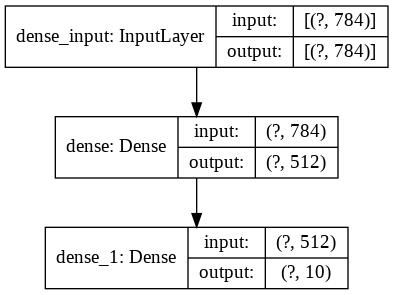

In [10]:
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model

red = models.Sequential()
red.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
red.add(layers.Dense(10, activation='softmax'))
plot_model(red, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Para facilitar la comprensión de esta introducción, hemos hecho uso de las utilidades de Keras para dar una representación visual de la estructura de la red. Ha de tenerse en cuenta que para ello es necesario instalar [Graphviz](http://www.graphviz.org) y la librería `pydot` de Python que se comunica con ella. Si no lo tienes configurado todavía, aquí tienes la salida esperada:

<img src="https://github.com/miguelamda/DL/blob/master/3.%20Frameworks%20Software/imgs/model_plot.png?raw=1" />

Además de las neuronas, que son las unidades atómicas que componen una red neuronal, desde un punto de vista funcional, el elemento básico de las redes neuronales es lo que se conoce como *capa* (*layer*), un módulo de procesamiento  formado por un conjunto de neuronas iguales que puede ver interpretarse como un "filtro" de datos. Como veremos a lo largo del curso, las capas son las encargadas de generar *representaciones* útiles de los datos que reciben, y que ayuden a resolver el problema para el que se ha construido la red. La mayor parte del Deep Learning, y donde esta demostrando un valor añadido respecto de los otros modelos de ML existentes, consiste en concatenar capas simples (y, posiblemente, con funcionalidades específicas diferenciadas) para obtener un dispositivo de cálculo que procesa datos de forma progresiva.

En el caso de la red que hemos definido, este dispositivo consta de una secuencia de dos capas densas, que son capas neurales totalmente conectadas. La segunda (y última) capa es una capa "softmax" de 10 salidas, lo que significa que devolverá un vector probabilístico de 10 valores (es decir, 10 valores en $[0,1]$ que suman 1). Cada uno de estos valores se interpretará la probabilidad de que la imagen actual pertenezca a una de las 10 clases (los dígitos del 0 al 9).

Hasta ahora solo hemos definido la estructura de la red, pero no hemos dado ninguna información acerca de cómo se llevará a cabo el entrenamiento. Para ello, hemos de indicarle a Keras algunas características adicionales, tales como el optimizador que permitirá modificar los pesos de la red, qué función objetivo (de error) se usará para dirigir esta optimización, y la métrica que usaremos para medir cómo se va comportando la red a medida que se entrena. 

Keras proporciona la función `compile` que permite establecer estas (y otras) propiedades sobre una red ya definida:


In [11]:
red.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Como se puede observar, muchas de las celdas de código no proporcionan una salida imprimible, sino que crean nuevas variables o modifican el contenido de algunas de ellas para su reutilización posterior.

Debido a que la red neuronal que vamos a usar debe recibir como dato de entrada cada imagen de forma aplanada (es decir, no como una matriz de 28x28, sino como un vector de 28x28=784 posiciones), nuestro primer paso es hacer uso de las instrucciones que proporciona Keras para transformar la forma de los datos de entrada. Además, aprovecharemos para normalizar el contenido de estas imágenes (están en escalas de grises con valores `uint8` entre 0 y 255, y las pasaremos a valores `float32` en $[0,1]$), algo aconsejable cuando se trabaja con este tipo de modelos:

<img src="https://s3.amazonaws.com/media-p.slid.es/uploads/970798/images/5546082/ezgif.com-video-to-gif__1_.gif" />


In [12]:
train_data = train_data.reshape((60000, 28 * 28))
train_data = train_data.astype('float32') / 255

test_data = test_data.reshape((10000, 28 * 28))
test_data = test_data.astype('float32') / 255

Además, vamos a convertir las etiquetas (que vienen en el dataset como valores enteros), en vectores binarios con one-hot encoding para que se correspondan con la salida que nuestra red puede proporcionar:

In [13]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

## 3. Proceso de entrenamiento

Preparados los datos y definida la red (estructura y funcionalidad), podemos hacer uso de la instrucción `fit` para comenzar el proceso de entrenamiento sobre los datos que tenemos. Esencialmente, hemos de indicar sobre qué datos entrenar (entrada y salidas), cuántas iteraciones (epochs) y con qué tamaño de batch (cada cuántos ejemplos el algoritmos actualiza los pesos).

Durante el proceso de entrenamiento, Keras informa de los valores que toma la función objetivo, así como de la/s métrica/s que hemos fijado en la compilación.

In [14]:
red.fit(train_data, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 4s 9ms/step - loss: 0.2578 - accuracy: 0.9253
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1041 - accuracy: 0.9696
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0698 - accuracy: 0.9797
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0504 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0369 - accuracy: 0.9891


Debemos tener en cuenta que los valores mostrados son el error y métricas calculados sobre los propios datos de entrenamiento. Sin embargo, como el objetivo de un modelo de aprendizaje es generalizar bien sobre datos que el proceso de entrenamiento no ha visto anteriormente, necesitamos el conjunto de test para evaluar cómo se comporta la red sobre ejemplos que no ha usado para ajustarse.

Sobre los datos de entrenamiento alcanzamos rápidamente una precisión de 0.989 (i.e. 98.9%), pero veamos cómo de bien se comporta con los datos de test (que no se han usado para aprender):

In [15]:
test_loss, test_acc = red.evaluate(test_data, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0689 - accuracy: 0.9786


In [16]:
print('test_acc:', test_acc)

test_acc: 0.978600025177002



Lo normal es que la red se comporte peor en los datos de test que en los datos de entrenamiento, ya que el proceso de entrenamiento consiste precisamente en ajustar los pesos para que el error cometido en estos últimos se minimice. Esta diferencia de comportamiento entre entrenamiento y test se denomina **overfitting** (o **sobreajuste**). En todo caso, con una red tan simple como la que hemos usado se alcanzan cotas de casi el 98% de aciertos.

Finalmente, podemos ver las predicciones que hace la red sobre algunos datos del conjunto de test (mostramos también las etiquetas aaociadas a los datos usados, pero ten en cuenta que están en formato binarizado, y el índice 1 corresponde a la etiqueta 0, el índice 2 a la etiqueta 1, etc...):

In [17]:
np.argmax(red.predict(test_data[2:3]))

1

In [18]:
test_labels[2:3]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Veamos mejor qué hemos obtenido. Puedes jugar con `x` para ver el resultado con otro ejemplo del conjunto de test.

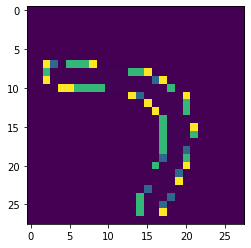

Etiqueta numérica:    [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Etiqueta categórica:  7
Predicción:           7


In [20]:
def muestra_imagen_prediccion(i):
    # mostrar imagen
    gen_image(test_data[i]*255).show()
    # mostrar la etiqueta en modo categórico
    print("Etiqueta numérica:   ",test_labels[i:(i+1)])
    # mostrar la etiqueta en numérico
    print("Etiqueta categórica: ",np.argmax(test_labels[i:(i+1)]))
    # mostrar la predicción de la red
    print("Predicción:          ",np.argmax(red.predict(test_data[i:(i+1)])))


x = 60 # prueba aquí otro número para ver otro ejemplo
muestra_imagen_prediccion(x)

Puedes usar el siguiente código para ver `k` ejemplos mal predichos.

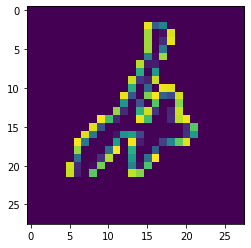

Etiqueta numérica:    [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Etiqueta categórica:  4
Predicción:           6


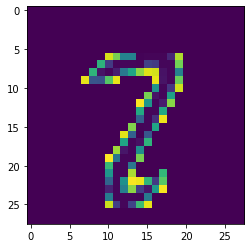

Etiqueta numérica:    [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Etiqueta categórica:  2
Predicción:           7


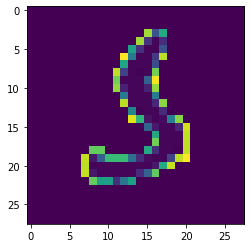

Etiqueta numérica:    [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Etiqueta categórica:  5
Predicción:           3


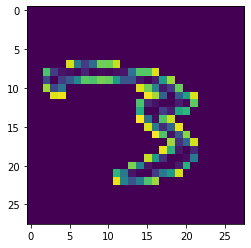

Etiqueta numérica:    [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Etiqueta categórica:  3
Predicción:           7


In [21]:
k=4
for i in range(0,len(test_data)):
    if np.argmax(red.predict(test_data[i:(i+1)])) != np.argmax(test_labels[i:(i+1)]):
        k=k-1
        if k<0:
            break;
        muestra_imagen_prediccion(i)

## 4. Ejercicio opcional para practicar

Juega con el entrenamiento del modelo para ver qué resultados obtienes y si consigues mejorar (o por el contrario se empeora el resultado): cambia el método de [optimización](https://keras.io/api/optimizers/), amplía el número de epochs, añade o quita capas, cambia las [funciones de activación](https://keras.io/api/layers/), etc. 